# Computer Lab: Quantile Regression

Olivier Fercoq

# Preparation
Please read the file TPquantile_regression_beginning.pdf for instructions on how to launch this notebook

In [1]:
%pylab
%matplotlib inline
sc = SparkContext.getOrCreate()

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
filename = 'ethylene_methane.txt'

In [3]:
dist_data = sc.textFile(filename)
dist_data.take(2)

['Time (seconds), Methane conc (ppm), Ethylene conc (ppm), sensor readings (16 channels) ',
 '0.00    0.00    0.00    -41.98  2067.64 -37.13  2.28    8.63    -26.62  -8.46   -0.33   3437.73 2728.14 4054.03 4007.89 4478.27 5056.98 3639.09 3128.49']

<div class="alert alert-success">We call filter to return a new DataFrame with a subset of the lines in the file (subset determined by a condition)

In [4]:
dist_data = dist_data.filter(lambda line: line[0:4] != 'Time')  # remove the first line
dist_data.first()

'0.00    0.00    0.00    -41.98  2067.64 -37.13  2.28    8.63    -26.62  -8.46   -0.33   3437.73 2728.14 4054.03 4007.89 4478.27 5056.98 3639.09 3128.49'

<div class="alert alert-success"> the map function is allowing us to use a function on all elements of the dataset.

In [5]:
s = dist_data.first()
print(s)
a = np.array(list(map(float, s.split())))
print(a)


0.00    0.00    0.00    -41.98  2067.64 -37.13  2.28    8.63    -26.62  -8.46   -0.33   3437.73 2728.14 4054.03 4007.89 4478.27 5056.98 3639.09 3128.49
[  0.00000000e+00   0.00000000e+00   0.00000000e+00  -4.19800000e+01
   2.06764000e+03  -3.71300000e+01   2.28000000e+00   8.63000000e+00
  -2.66200000e+01  -8.46000000e+00  -3.30000000e-01   3.43773000e+03
   2.72814000e+03   4.05403000e+03   4.00789000e+03   4.47827000e+03
   5.05698000e+03   3.63909000e+03   3.12849000e+03]


In [6]:
dist_data = dist_data.map(lambda line: np.array(list(map(float,line.split()))))
dist_data.first()

array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        -4.19800000e+01,   2.06764000e+03,  -3.71300000e+01,
         2.28000000e+00,   8.63000000e+00,  -2.66200000e+01,
        -8.46000000e+00,  -3.30000000e-01,   3.43773000e+03,
         2.72814000e+03,   4.05403000e+03,   4.00789000e+03,
         4.47827000e+03,   5.05698000e+03,   3.63909000e+03,
         3.12849000e+03])

In [7]:
# We take about half of the data for the training set

In [8]:
train_data_full = dist_data.filter(lambda row: row[0] < 42082.60 / 2.)


In [9]:
# In order to make development smoother, we first consider 1/100th of the training data. 
# This can be changed when the algorithm is operational.

In [10]:
train_data_full.cache()  # Otherwise, all previous filter operations are re-run each time an action is taken.

freq = 100
train_data = train_data_full.filter(lambda row: int(row[0]*100) % freq == 0)
train_data.cache()  # Otherwise, all previous filter operations are re-run each time an action is taken.


PythonRDD[7] at RDD at PythonRDD.scala:48

<div class="alert alert-success">
Spark RDD reduce function reduces the elements of this RDD using the specified commutative and associative binary operator.  
the execution of this operation results in distributing the data across the multiple partitions.  
It is a wide operation as it is shuffling data from multiple partitions and reduces to a single value  
It accepts a Commutative and Associative function as an argument: 
    - The parameter function should have two arguments of the same data type  
    - The return type of the function also must be same as argument types  


In [11]:
def standardize(train_data):
    print('before centering', train_data.first())
    row_sums = train_data.reduce(lambda a, b: a + b)
    print('nb of columns', row_sums.shape)
    n_train = train_data.count()
    print('nb of observations', n_train)

    row_means = row_sums / n_train
    print('row_means', row_means)

    train_data = train_data.map(lambda r: r - row_means)
    print('after centering', train_data.first())

    row_stds = np.sqrt(train_data.map(lambda r: r ** 2).reduce(lambda a, b: a + b) / n_train)
    print('row_stds', row_stds)
    train_data = train_data.map(lambda r: r / row_stds)
    print('after standardizing', train_data.first())

    row_sums_should_be_0 = train_data.reduce(lambda a, b: a + b)
    print('this should be 0', row_sums_should_be_0)
    row_stds_should_be_1 = np.sqrt(train_data.map(lambda r: r ** 2).reduce(lambda a, b: a + b) / n_train)
    print('this should be 1', row_stds_should_be_1)

    return train_data



train_data = standardize(train_data)
train_data_NotDistributed = np.array(train_data.collect())  # collect() should be used only on small RDDs

train_data_full = standardize(train_data_full)



before centering [  0.00000000e+00   0.00000000e+00   0.00000000e+00  -4.19800000e+01
   2.06764000e+03  -3.71300000e+01   2.28000000e+00   8.63000000e+00
  -2.66200000e+01  -8.46000000e+00  -3.30000000e-01   3.43773000e+03
   2.72814000e+03   4.05403000e+03   4.00789000e+03   4.47827000e+03
   5.05698000e+03   3.63909000e+03   3.12849000e+03]
nb of columns (19,)
nb of observations 24764
row_means [  1.22635033e+04   6.52015652e+01   3.96160394e+00   2.45430267e+03
   1.76305532e+03   2.75705064e+03   3.04433692e+03   1.95226315e+03
   2.49947013e+03   2.67255789e+03   2.97321209e+03   3.47290366e+03
   2.76907937e+03   2.25275025e+03   2.01260047e+03   1.76457931e+03
   1.89374477e+03   2.25722566e+03   1.83294130e+03]
after centering [ -1.22635033e+04  -6.52015652e+01  -3.96160394e+00  -2.49628267e+03
   3.04584679e+02  -2.79418064e+03  -3.04205692e+03  -1.94363315e+03
  -2.52609013e+03  -2.68101789e+03  -2.97354209e+03  -3.51736553e+01
  -4.09393668e+01   1.80127975e+03   1.99528953

# Distributed least squares

let's solve the least square error with parallel computation.


let's consider the following problem:
$$ (1) \; \min_{w \in \mathbb{R}^{dx2}} \frac{1}{2}||Xw_{:,ethylene} - y_{:,ethylene}||^2 + \frac{1}{2}||Xw_{:,methane} - y_{:,methane}||^2   $$
we can first see that's this problem can be rewritten as such:
$$ (1) \; \min_{w \in \mathbb{R}^{d}} \frac{1}{2}||Xw - y_{:,ethylene}||^2 +  \min_{w' \in \mathbb{R}^{d}}\frac{1}{2}||Xw' - y_{:,methane}||^2   $$

those two least square problem can be solved by derivating the objective function we want to minimize:  
let's call $f$ the function define by $f(w) = \frac{1}{2} ||Xw - y||^2$ then the derivate is given by: $\frac{df}{dw}(w) = X^T(Xw-y)$ and we find the minimizer from this expression:
$$ w = (X X^T)^{-1}X^Ty$$  
or, depending on the form we want:
$$ (XX^T)w = X^Ty$$

applying this form to the problem 1 gives us that the solution to the least squares problem is the solution to a linear system of equations of a moderate size.
$$
\left\{
    \begin{array}{ll}
        (XX^T)w_{:,ethylene} = X^Ty_{:,ethylene} \\
       (XX^T)w_{:,methane} = X^Ty_{:,methane}
    \end{array}
\right.
$$

this can be rewritten to find the exact solution:
$$
\left\{
    \begin{array}{ll}
        w_{:,ethylene} = (XX^T)^{-1}X^Ty_{:,ethylene} \\
       w_{:,methane} = (XX^T)^{-1}X^Ty_{:,methane}
    \end{array}
\right.
$$

we now use this to solve the problem:

In [12]:
import numpy as np
#lsp = least square problem
def lsp(X):
    xtx = X.map(lambda row  : np.outer(row[3:], row[3:])).reduce(lambda a, b : a + b)
    xty_m = X.map(lambda row  : row[1] * row[3:]).reduce(lambda a, b : a + b)
    xty_e = X.map(lambda row  : row[2] * row[3:]).reduce(lambda a, b : a + b)
    y= [np.linalg.solve(xtx,xty_e),np.linalg.solve(xtx,xty_m)]
    return(y)

In [13]:
lsp(train_data)

[array([ 0.05785333, -0.01648893,  5.98149872, -3.26804662,  2.19818637,
        -0.85176119, -6.17691052,  1.68331876,  0.20878866, -0.38228381,
        -2.82765122, -1.62830299, -0.1201385 , -0.98787302,  5.39467748,
         1.38404938]),
 array([ 0.05067342,  0.01360923, -0.11311798,  0.3867774 , -7.16841568,
         4.64021876,  1.45738644,  1.21366416, -0.83444129,  0.70229529,
         1.86491802, -3.34056305,  0.67064626,  2.5687135 , -0.01066947,
        -1.2251673 ])]

In [14]:
lsp(train_data_full)

[array([ 0.0485206 , -0.01502376,  5.88192701, -3.28065969,  2.31979054,
        -1.15516419, -5.54778859,  1.35446226,  0.33945828, -0.46888552,
        -2.64645593, -1.90203955, -0.40600687, -0.491782  ,  4.89059757,
         1.72824999]),
 array([ 0.09682988,  0.01240669, -0.14024083,  0.34187629, -6.83667423,
         4.59287714,  0.99581238,  1.39054027, -0.867363  ,  0.69831324,
         1.81161887, -3.18783061,  0.22809633,  2.78471187,  0.08956648,
        -1.11281948])]

# Quantile regression with linear kernels:serial algorithm

let's take a $\gamma>0$  
we now calculate $prox_{\gamma f_2}(v)$
we have:
$$
\begin{align}
 \\prox_{\gamma f_2}(v) 
& = \arg\!\min_x (\gamma f_2(x) +\frac{1}{2}||x-v||^2_2)\\
& = \arg\!\min_x (\gamma L_{\tau}(y-x) +\frac{1}{2}||x-v||^2_2)\\
& = \arg\!\min_x (\gamma \max\{-(1-\tau)(y-x),\tau(y-x)\} +\frac{1}{2}||x-v||^2_2)\\
\end{align}
$$

here we make a case distiction. $(x-y)>0$, $x=y$ or $(x-y)<0$

if $(x-y)>0$:  
$$
\begin{align}
 \\prox_{\gamma f_2}(v) 
& = \arg\!\min_x (\gamma \tau(y-x) + \frac{1}{2}(x-v)^2)\\
\end{align}
$$
we derive and we find: $x= v+\gamma \tau$

if $(x-y)<0$:
$$prox_{\gamma f_2}(v) = \arg\!\min_x (-\gamma(1- \tau)(y-x) + \frac{1}{2}(x-v)^2) $$
we derive and we find: $x= v-\gamma(1- \tau)$

Having found that we can now conclude:
$$
prox_{\gamma f_2}(v) = 
\left\{
    \begin{array}{ll}
       v+\gamma \tau \; \text{if} :\; y-\gamma \tau>v   \\
       v - \gamma(1-\tau) \; \text{if} :\; y+\gamma(1-\tau)<v \\
       \text{else} \; x=y \\
    \end{array}
\right.
$$

given the problem (3) we can find the matrix and the two functions:  
$$ f_1(w,w_0) = \frac{\alpha}{2}||w||^2_F$$
$$M(w,w_0) = Xw + w_0(1....1)^T = (1_d X)\begin{pmatrix} w\\w_0 \end{pmatrix}$$
$$ f_2(M(w,w_0)) = \sum_{g=1}^2 \sum_{i=1}^n (L_{\tau}(y_{i,g} - M(w,w_0)_{i,g}))$$
where $1_d$ is a vector column of size n filled with 1.


let's now write the ADMM steps to solve the following problem:
$$ \inf_{(w_0,w)} f + g\circ M$$
from the class we have:  
$$
\left\{
    \begin{array}{ll}
        x^{k+1} = \arg\!\min_x (f(x) + <\phi^k,Mx> + \frac{1}{2}||Mx-z^k||^2) \\
        z^{k+1} = \arg\!\min_z (g(z) - <\phi^k,z> + \frac{1}{2\gamma}||Mx^{k+1}-z||^2)\\
        \phi^{k+1} = \phi^k + \frac{1}{\gamma}(Mx^{k+1} - z^{k+1}) \\
    \end{array}
\right.
$$
we now need to adapt this to the current situation. let's first take care of the first line. We can derivate this expression to find the minimum. It comes:
$$ \alpha \begin{pmatrix} 0 & 0 \\ 0 & I_n \end{pmatrix} x + M^T \phi^k + \frac{1}{\gamma}M^T(M x - z^k) = 0 $$
hence:
$$x = (\alpha \begin{pmatrix} 0 & 0 \\ 0 & I_n \end{pmatrix} + \frac{1}{\gamma}M^TM)^{-1} M^T(\frac{z^k}{\gamma}-\phi^k) $$
for the second line we will transform a little the expression to get the prox function we had calculate above.
$$
\begin{align}
 \\z^{k+1}
& = \arg\!\min_z (g(z) - <\phi^k,z> + \frac{1}{2\gamma}||Mx^{k+1}-z||^2\\
& = \arg\!\min_z (g(z) - \frac{1}{2}<\phi^k,z> -\frac{1}{2}<z,\phi^k>+ \frac{1}{2\gamma}<Mx^{k+1}-z,Mx^{k+1}-z>)\\
& = \arg\!\min_z (g(z) + \frac{1}{2}<\phi^k,Mx^{k+1} - z> + \frac{1}{2}<Mx^{k+1} - z,\phi^k>+ \frac{1}{2\gamma}<Mx^{k+1}-z,Mx^{k+1}-z>)\\
& = \arg\!\min_z (g(z)  + \frac{1}{2}<Mx^{k+1} - z,\phi^k>+ \frac{1}{2\gamma}<Mx^{k+1} + \gamma \phi^k -z,Mx^{k+1}-z>)\\
& = \arg\!\min_z (g(z)  + \frac{1}{2}<Mx^{k+1}+ \gamma \phi^k - z,\phi^k>+ \frac{1}{2\gamma}<Mx^{k+1} + \gamma \phi^k -z,Mx^{k+1}-z>)\\
& = \arg\!\min_z (g(z) + \frac{1}{2\gamma}<Mx^{k+1} + \gamma \phi^k -z,Mx^{k+1} + \gamma \phi^k -z>)\\
& = \arg\!\min_z (g(z) + \frac{1}{2\gamma}||Mx^{k+1} + \gamma \phi^k -z||^2)\\
& = prox_{\gamma g} (Mx^{k+1} + \gamma \phi^k)
\end{align}
$$
it's here a generalisation of the function define for the vector as the function applied for every coordinates.  
we can now rewrite the steps as follow:
$$
\left\{
    \begin{array}{ll}
        x^{k+1} = (\alpha \begin{pmatrix} 0 & 0 \\ 0 & I_n \end{pmatrix} + \frac{1}{\gamma}M^TM)^{-1} M^T(\frac{z^k}{\gamma}-\phi^k)\\
        z^{k+1} = prox_{\gamma g} (Mx^{k+1} + \gamma \phi^k)\\
        \phi^{k+1} = \phi^k + \frac{1}{\gamma}(Mx^{k+1} - z^{k+1}) \\
    \end{array}
\right.
$$

In [55]:
#we first compute the functions we will need

def prox(v,y,gamma,tau):
    if (y>v+gamma*tau):
        return(v+gamma*tau)
    if(y<v-gamma*(1-tau)):
        return(v-gamma*(1-tau))
    return y


def ADMM(X,n_iter=100,alpha=1,tau=0.9,gamma=1):
    x = [[0,0]]*(len(X[:3])+1)
    z = [[0,0]]*(len(X[1]))
    Y =[X[1],X[2]]
    M = np.concatenate(([[1]*len(X[1])],X[:3]))
    phi = z
    err = []
    #######################
    I = np.identity(len(X[1]))
    print(len(X[1]))
    I[0][0] = 0 
    A = np.linalg.inv(alpha*I + (np.dot(M.T,M))/gamma)
    A = np.dot(A,M.T).T
    ########################
    for i in range(n_iter):
        ############################
        x = np.dot(A,np.subtract(z,phi))
        ############################
        V = np.dot(M.T,x)+gamma*phi
        for j in range(len(z[1])):
            z[0][j] = prox(V[0][j],Y[0][j],gamma,tau)
            z[1][j] = prox(V[1][j],Y[1][j],gamma,tau)
        ############################
        phi +=(np.dot(M.T,x)-z)
        err.append(np.linalg.norm(np.dot(M.T,x)-z))
    return(err)

19


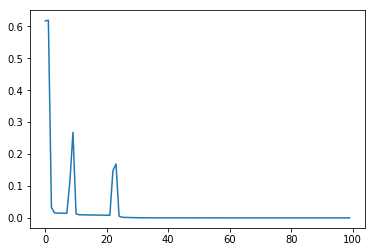

In [65]:
plt.plot(ADMM(train_data_NotDistributed))

# Parallel algorithm

In [57]:
train_data_with_z_and_mu = train_data.map(lambda row: {'y' : row[1:3],'x' : row[3:],'z' : np.zeros(2),'mu' : np.zeros(2)})

In [95]:
def ADMM_para(X,n_iter=100,alpha=1,tau=0.9,gamma=1):
    P = X.map(lambda row: {'y' : row[1:3],'X' : row[3:],'z' : np.zeros(2),'mu' : np.zeros(2),'phi': np.zeros(2),'M':np.concatenate(([1],row[3:]))})
    P.cache()
    phi = np.zeros(2)
    err = []
    #######################
    I = np.identity((17))
    I[0][0] = 0 
    A = (alpha*I + (P.map(lambda row  : np.outer(row['M'],row['M'])).reduce(lambda a, b : a + b)))*(gamma)
    ########################
    for i in range(n_iter):
        print(i)
        ############################
        mu = np.linalg.solve(A,np.dot(P.map(lambda row : row['M']),np.subtract(P.map(lambda row : row['z'],P.map(lambda row : row['phi'])))))
        ############################
        V = np.dot(P.map(lambda row : row['M']),P.map(lambda row : row['mu']))+gamma*P.map(lambda row : row['phi'])
        for j in range(len(z[1])):
            P.map(lambda row: np.outer(row))
            z[0][j] = prox(V[0][j],Y[0][j],gamma,tau)
            z[1][j] = prox(V[1][j],Y[1][j],gamma,tau)
        ############################
        phi +=(np.dot(M.T,mu)-z)
        err.append(np.linalg.norm(np.dot(M.T,mu)-z))
    return(err)

In [96]:
ADMM_para(train_data)

0


ValueError: invalid number of arguments